In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy
import pickle

In [2]:
warnings.simplefilter("ignore")

howmanydifs = 3
allvalues_perset = pickle.load(open("./data/allvalues_perset.p", "rb"))
methods = pickle.load(open("./data/methods.p", "rb"))
fullsetnames = pickle.load(open("./data/fullsetnames.p", "rb"))
functionals = pickle.load(open("./data/functionals.p", "rb"))
basis_sets = pickle.load(open("./data/basis_sets.p", "rb"))
supersetnames = pickle.load(open("./data/supersetnames.p", "rb"))

In [3]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

insidemethods = ["W","D3(0)","D3(BJ)"]
for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmad = None
        fulllist = list(supersetnames.keys()) + ["Full"]
        if setname in fulllist:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestinsidemethod_wtmad:
                models_results[setname].bestinsidemethod_wtmad = wtmad
                models_results[setname].bestinsidemethod_name_wtmad = insidemethods[methodid]
                models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = insidemethods[methodid]
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmad = None            
        fulllist = list(supersetnames.keys()) + ["Full"]
        if setname in fulllist:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestourmethod_wtmad:
                models_results[setname].bestourmethod_wtmad = wtmad
                models_results[setname].bestourmethod_name_wtmad = method
                models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

bestmnethodscount = {}
setofbestourmethodswtamd = {}

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in fullsetnames:
    if models_results[setname].bestourmethod_name_rmse in bestmnethodscount:
        bestmnethodscount[models_results[setname].bestourmethod_name_rmse] += 1
    else:
        bestmnethodscount[models_results[setname].bestourmethod_name_rmse] = 1

    if models_results[setname].bestourmethod_name_wtmad != "":
        if models_results[setname].bestourmethod_name_wtmad in setofbestourmethodswtamd:
            setofbestourmethodswtamd[models_results[setname].bestourmethod_name_wtmad] += 1
        else:
            setofbestourmethodswtamd[models_results[setname].bestourmethod_name_wtmad] = 1
          
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           W  ,    8.201  ,           W  ,   17.010  ,   PBE0-TZVP  ,    4.856  ,   PBE0-TZVP  ,   10.520
                    BARRIER_HEIGHTS_BH76  ,           W  ,   10.387  ,              ,      inf  ,   PBE0-TZVP  ,    5.505  ,              ,      inf
                 BARRIER_HEIGHTS_BHDIV10  ,           W  ,    9.191  ,              ,      inf  ,   PBE0-TZVP  ,    5.278  ,              ,      inf
                  BARRIER_HEIGHTS_BHPERI  ,           W  ,    4.407  ,              ,      inf  ,   PBE0-TZVP  ,    3.762  ,              ,      inf
                 BARRIER_HEIGHTS_BHROT27  ,       D3(0)  ,    0.611  ,              ,      inf  ,    PBE-TZVP  ,    0.718  ,              ,      inf
                   BARRIER_HE

In [5]:
print("RMSE")
for method in bestmnethodscount:
    print("Best our method ", method, " count: ", bestmnethodscount[method])

print()
print("WTMAD2")
for method in setofbestourmethodswtamd:
    print("Best our method ", method, " count: ", setofbestourmethodswtamd[method])


RMSE
Best our method  PBE0-TZVP  count:  33
Best our method  PBE-TZVP  count:  4
Best our method  TPSSh-TZVP  count:  15
Best our method  TPSS-TZVP  count:  5
Best our method  TPSS-MINIX  count:  1
Best our method  PBE0-MINIX  count:  2
Best our method  PBE0-SVP  count:  1

WTMAD2
Best our method  PBE0-TZVP  count:  5
Best our method  TPSSh-TZVP  count:  1


In [6]:
#filter and generate equations
basicfeattouse = ["Potential_Energy", \
                "Kinetic_Energy", \
                "FINAL_SINGLE_POINT_ENERGY", \
                "Dispersion_correction", \
                "E(C)", \
                "E(X)", \
                "Two_Electron_Energy", \
                "Nuclear_Repulsion", \
                "One_Electron_Energy"]

featuresvalues_perset = {}
for setname in fullsetnames:
    featuresvalues_perset [setname] = []
    for val in allvalues_perset[setname]:
        featuresvalues_perset[setname].append({})
        for k in val:
            if k.find("energydiff") != -1:
                torm = k.replace("energydiff", "")
                for f in val[k]:
                    tocheck = f.replace(torm, "")
                    if tocheck in basicfeattouse:
                        keytouse = f.replace("-", "_")
                        keytouse = keytouse.replace("(", "")
                        keytouse = keytouse.replace(")", "")
                        featuresvalues_perset[setname][-1][keytouse] = val[k][f]

# for debug purposes
#for val in featuresvalues_perset:
#    print("======= START =======")
#    print(val, len(featuresvalues_perset[val]))
#    pp.pprint(featuresvalues_perset[val])
#    print("=======  END  =======")


In [7]:
equations = {"EC" :"EC" , \
            "EX" : "EX", \
            "SPE" : "FINAL_SINGLE_POINT_ENERGY", \
            "DC" : "Dispersion_correction", \
            "PE" : "Potential_Energy", \
            "KE" : "Kinetic_Energy", \
            "OEE" : "One_Electron_Energy", \
            "TEE" : "Two_Electron_Energy", \
            "NR" : "Nuclear_Repulsion"}

eq_featuresvalues_perset = \
    commonutils.equation_parser_compiler(equations, functionals, basis_sets, basicfeattouse, \
                              featuresvalues_perset)

# for debug purposes
#for setname in featuresvalues_perset:
#    print("Equations for ", setname , " set ", len(featuresvalues_perset[setname]))
#    pp.pprint(eq_featuresvalues_perset[setname])
#
#featuresvalues_perset = deepcopy(eq_featuresvalues_perset)

In [8]:
#build descriptors 
# functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
# basis_sets = ['MINIX', 'SVP', 'TZVP']
# basicfeattouse = ["Potential_Energy", \
#                 "FINAL_SINGLE_POINT_ENERGY", \
#                 "Kinetic_Energy", \
#                 "Dispersion_correction", \
#                 "E(C)", \
#                 "E(X)", \
#                 "Two_Electron_Energy", \
#                 "Nuclear_Repulsion", \
#                 "One_Electron_Energy"]
selected_basisset = "TZVP"
selected_functional = "PBE0"
functionals = ["PBE0"]
basis_sets = ['SVP']

sep = "_"
for setname in fullsetnames:
    desciptors = {}
    k = selected_functional + sep + \
            selected_basisset 
    for features in eq_featuresvalues_perset[setname]:
        for val in features:
            if val.find(k) != -1:
                if val not in desciptors:
                    desciptors[val] = [features[val]]
                else:
                    desciptors[val].append(features[val])

    for features in eq_featuresvalues_perset[setname]:
        for val in features:
            for func in functionals:
                for basis in basis_sets:
                    if not(basis == selected_basisset and \
                           func == selected_functional):
                        if val.find(func + sep + basis) != -1:
                            actualk = val 
                            refk  = selected_functional + sep  + selected_basisset + \
                                val.replace(func + sep + basis, "")
                            newk = actualk + "_difftoref"
                            if newk not in desciptors:
                                desciptors[newk] = [features[actualk]-features[refk]]
                            else:
                                desciptors[newk].append(features[actualk]-features[refk])
    
    models_results[setname].features = desciptors
    #print("Descriptors for ", setname)
    #for k in desciptors:
    #    print(k, len(desciptors[k]), desciptors[k])

# feastures selection
setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

toremove = []
setname = "Full"
for k in models_results[setname].features:
    if len(set(models_results[setname].features[k])) == 1:
        toremove.append(k)
        print("Constant fatures to remove: ", k)

# remove constant values
for setname in fullsetnames:
    #print("Removing constant features for ", setname)
    for k in toremove:
        #print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
print("Removing Nuclear Repulsion difference")
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("NR_difftoref") != -1:
            toremove.append(k)
    for k in toremove:
        #print("Removing feature ", k)
        del models_results[setname].features[k]

setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

Number of features for  18
Constant fatures to remove:  PBE0_SVP_DC_difftoref
Constant fatures to remove:  PBE0_SVP_NR_difftoref
Removing Nuclear Repulsion difference
Number of features for  16


In [9]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

In [10]:
########################################################################################

def mean_absolute_percentage_error(y_pred, y_true):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        
    return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

########################################################################################

def mean_average_error(y_pred, y_true):
       
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred) 
    
    return np.mean(np.abs(y_pred - y_true))
    
########################################################################################

def mean_absolute_error(y_pred, y_true):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    return np.mean(np.abs(y_true - y_pred))

########################################################################################

def residual_sum_square(y_pred, y_true):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    return np.sum((y_true - y_pred)**2)

########################################################################################

loss_function = mean_absolute_percentage_error

Running LR for dataset:  Full
   1.67106e-02    4.24781e-01
  -1.80002e-01   -1.06147e-01
  -1.44456e-02   -3.21140e-02
   6.27624e-02   -4.67817e+05
   1.40562e+00    4.67817e+05
   3.36683e-01   -1.39084e+08
   3.38149e-01   -1.39084e+08
   5.78806e-01    1.39552e+08
   5.78173e-01    1.39552e+08
   5.79443e-01    1.39552e+08
   1.03097e-01   -1.86438e-01
   4.64228e-02   -8.41006e-02
  -6.85313e-01    3.23057e+08
   1.47410e-01    4.77207e+07
   1.67270e-01    4.77207e+07
   1.52736e-01   -3.70778e+08
   1.61957e-01   -3.70778e+08
        Optimized final loss function:   26.63535
Linear Regression FINAL loss function:   45.39202


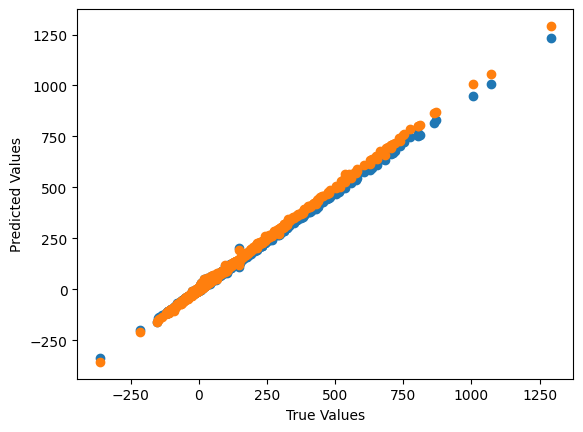

In [11]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

########################################################################################

def objective_function(beta, X, Y):
    error = loss_function(np.matmul(X,beta), Y)
    return(error)

########################################################################################

setname = "Full"
print("Running LR for dataset: ", setname)

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].features, \
              models_results[setname].labels)

# remove alla values lower than zero from the Y set and X set
#idx = np.where(Y < 0)
#Y = np.delete(Y, idx)
#X = np.delete(X, idx, axis=0)

# Add an intercept column to the model.
Xn = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)

lm = LinearRegression()
lm.fit(X, Y)

met = "BFGS"
"""
Nelder-Mead
Powell
CG
BFGS
Newton-CG
L-BFGS-B
TNC
COBYLA
COBYQA
SLSQP
trust-constr
dogleg
trust-ncg 
trust-exact 
trust-krylov
"""

# Starting point for the optimization algorithm
beta_init = np.array([1]*Xn.shape[1])
result = minimize(objective_function, beta_init, args=(Xn,Y),
                  method=met, options={'maxiter': 1000})

beta_hat = result.x

for i, b in enumerate(beta_hat):
    if i == 0:
        print("%14.5e %14.5e"%(b, lm.intercept_))
    else:
        print("%14.5e %14.5e"%(b, lm.coef_[i-1]))

#print(result)
optlf = loss_function(np.matmul(Xn,beta_hat), Y)
lrlf = loss_function(lm.predict(X), Y)

print("        Optimized final loss function: %10.5f"%(optlf))
print("Linear Regression FINAL loss function: %10.5f"%(lrlf))

# scatter plot
plt.scatter(Y, np.matmul(Xn,beta_hat))
plt.scatter(Y, lm.predict(X))
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()
